In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp

# Chicago set

CSV file available from https://catalog.data.gov/dataset/crimes-one-year-prior-to-present-e171f

In [8]:
import open_cp.sources.chicago as chicago

points = chicago.default_burglary_data()
points

In [9]:
len(points.timestamps), points.time_range

(59209,
 (numpy.datetime64('2016-03-17T05:06:00.000'),
  numpy.datetime64('2017-03-16T23:30:00.000')))

In [12]:
bbox = points.bounding_box
print("X coord range:", bbox.xmin, bbox.xmax)
print("Y coord range:", bbox.ymin, bbox.ymax)
print(bbox.aspect_ratio)

X coord range: 334018.117311 367319.649846
Y coord range: 552879.750308 594819.314566
1.25938841447


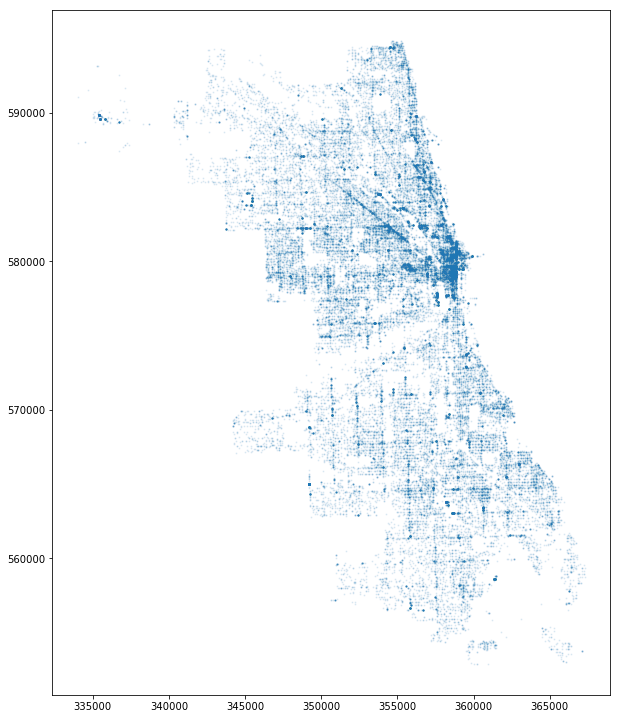

In [13]:
_, ax = plt.subplots(figsize=(10,10 * bbox.aspect_ratio))
ax.scatter(points.coords[0], points.coords[1], alpha=0.1, marker="o", s=1)

As an American city, most streets run North-South or East-West.  Further, the data is geocoded to the centre of the "block", to anonymise the data.  (Though this is slightly inconsistent, if one looks closely at the raw CSV file.)

In the plot above:

   - the clump at the upper left is the airport.
   - We see a large clump of theft data downtown.
   - It would be interesting to know what causes the visible lines running north north west from downtown.

In [15]:
mask = ( (points.xcoords >= 355000) & (points.xcoords <= 365000) &
        (points.ycoords >= 575000) & (points.ycoords <= 585000) )

downtown = points[mask]

bbox = downtown.bounding_box
print("X coord range:", bbox.xmin, bbox.xmax)
print("Y coord range:", bbox.ymin, bbox.ymax)

X coord range: 355000.54864 360647.882859
Y coord range: 575007.0104 584997.43968


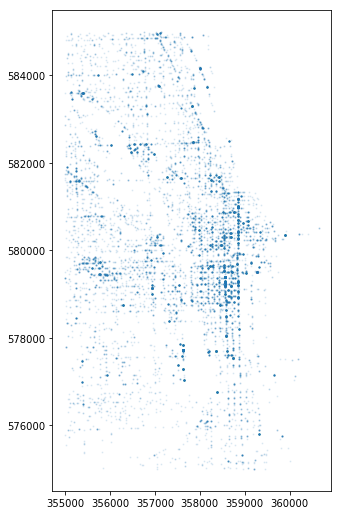

In [16]:
_, ax = plt.subplots(figsize=(5, 5 * bbox.aspect_ratio))
ax.scatter(downtown.coords[0], downtown.coords[1], alpha=0.1, marker="o", s=1)

# UK Crime data

We use an example of January 2017 from West Yorkshire.

In [18]:
import open_cp.sources.ukpolice as ukpolice
points = ukpolice.default_burglary_data()
len(points.timestamps)

2358

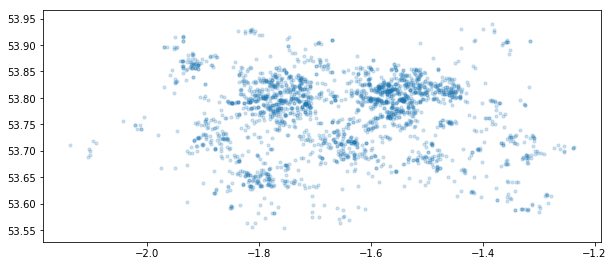

In [20]:
bbox = points.bounding_box

fig, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(points.xcoords, points.ycoords, s=10, alpha=0.2)

These are longitude / latitude points, which distort distance.  Assuming you have `pyproj` installed, you can project.  For the UK, we use [British National Grid](http://www.spatialreference.org/ref/epsg/osgb36-british-national-grid-odn-height/)

In [21]:
import open_cp

In [22]:
projected_points = open_cp.data.points_from_lon_lat(points, epsg=7405)

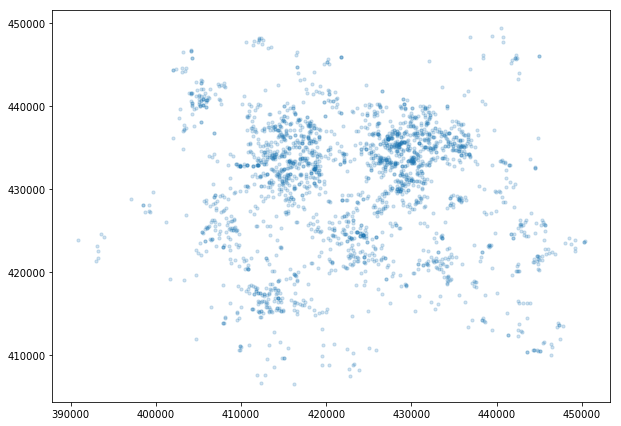

In [24]:
bbox = projected_points.bounding_box

fig, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(projected_points.xcoords, projected_points.ycoords, s=10, alpha=0.2)

# Random data

In [25]:
import open_cp.sources.random as random
import datetime

In [27]:
region = open_cp.RectangularRegion(390000, 450000, 410000, 450000)
points = random.random_uniform(region, datetime.date(2017,1,1), datetime.date(2017,3,1), 1000)

points.time_range

(numpy.datetime64('2017-01-01T00:32:34.000'),
 numpy.datetime64('2017-02-28T23:40:05.000'))

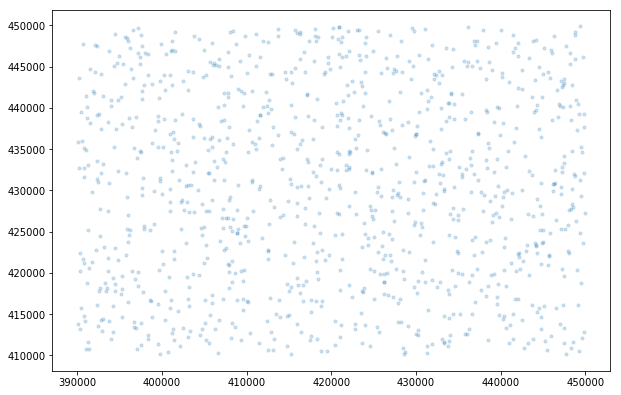

In [28]:
bbox = points.bounding_box

fig, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(*points.coords, s=10, alpha=0.2)

If we have scipy installed, we can quickly use a 2D Gaussian kernel density estimation to get an estimate of the "risk intensity" from the real West Yorkshire data.

In [29]:
import scipy.stats

In [30]:
kernel = scipy.stats.gaussian_kde(projected_points.coords)

In [31]:
X, Y = np.mgrid[bbox.xmin:bbox.xmax:100j, bbox.ymin:bbox.ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
np.max(Z)

3.2119615222277069e-09

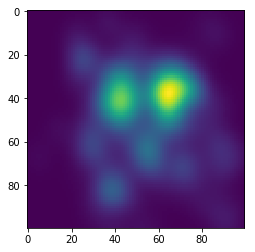

In [32]:
plt.imshow(np.rot90(Z))

In [33]:
sampler = random.KernelSampler(region, kernel, 4e-9)
points = random.random_spatial(sampler, datetime.date(2017,1,1), datetime.date(2017,3,1), 2350)

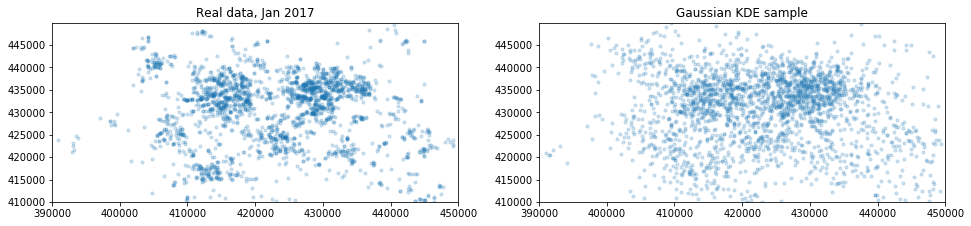

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].scatter(*projected_points.coords, s=10, alpha=0.2)
ax[1].scatter(*points.coords, s=10, alpha=0.2)
for i in [0, 1]:
    ax[i].set_aspect(bbox.aspect_ratio)
    ax[i].set(xlim=[bbox.xmin, bbox.xmax], ylim=[bbox.ymin, bbox.ymax])
ax[0].set_title("Real data, Jan 2017")
_ = ax[1].set_title("Gaussian KDE sample")

The real plot still looks somewhat different to the random test data, suggesting that a simple fixed bandwidth Gaussian KDE is not appropriate (which we already knew...)

## Using a nearest neighbour variable bandwidth Gaussian KDE

In [36]:
import open_cp.kernels

In [59]:
kernel = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(projected_points.coords, k=10)
sampler = random.KernelSampler(region, kernel, 4e-9)
points10 = random.random_spatial(sampler, datetime.date(2017,1,1), datetime.date(2017,3,1), 2350)

kernel = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(projected_points.coords, k=25)
sampler = random.KernelSampler(region, kernel, 4e-9)
points25 = random.random_spatial(sampler, datetime.date(2017,1,1), datetime.date(2017,3,1), 2350)

kernel = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(projected_points.coords, k=50)
sampler = random.KernelSampler(region, kernel, 4e-9)
points50 = random.random_spatial(sampler, datetime.date(2017,1,1), datetime.date(2017,3,1), 2350)

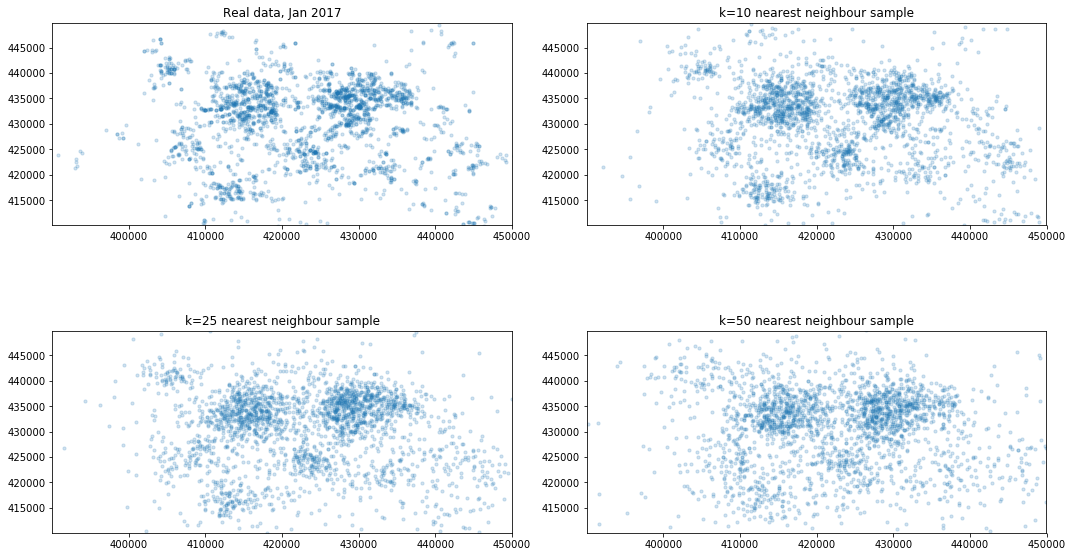

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
ax[0,0].scatter(*projected_points.coords, s=10, alpha=0.2)
ax[0,1].scatter(*points10.coords, s=10, alpha=0.2)
ax[1,0].scatter(*points25.coords, s=10, alpha=0.2)
ax[1,1].scatter(*points50.coords, s=10, alpha=0.2)
for a in ax.ravel():
    a.set_aspect(bbox.aspect_ratio)
    a.set(xlim=[bbox.xmin, bbox.xmax], ylim=[bbox.ymin, bbox.ymax])
ax[0,0].set_title("Real data, Jan 2017")
ax[0,1].set_title("k=10 nearest neighbour sample")
ax[1,0].set_title("k=25 nearest neighbour sample")
ax[1,1].set_title("k=50 nearest neighbour sample")
fig.tight_layout()
None

Visually, having a rather narrow bandwidth seems to look better.

I suspect that to produce more realistic simulations, to _geography_ of the data needs to be investigated: i.e. locate the points onto buildings and into the real street network.

# Self-exciting point process sampler

## Inhomogeneous Poisson process

In [2]:
import open_cp.sources.sepp as sepp

In [3]:
region = open_cp.RectangularRegion(0,100,0,100)
kernel = sepp.PoissonTimeGaussianSpace(1, [50, 50], [150, 25], 0.8)

sampler = sepp.InhomogeneousPoisson(region, kernel)

In [4]:
points = sampler.sample(0, 100)

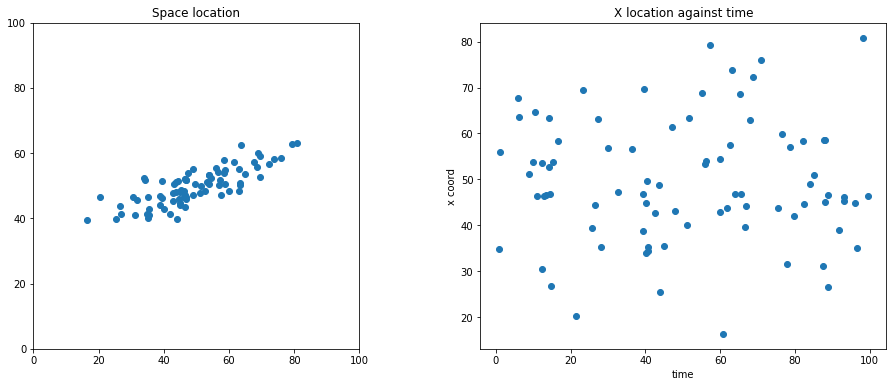

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].scatter(points[1], points[2])
ax[0].set_title("Space location")
ax[0].set_aspect(1)
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[1].scatter(points[0], points[1])
ax[1].set_xlabel("time")
ax[1].set_ylabel("x coord")
ax[1].set_title("X location against time")
None

The coordinates in space give samples from a 2D correlated Gaussian distribution, as we expect.

If we do this repeatedly, then the time coordinates along should give a poisson process.

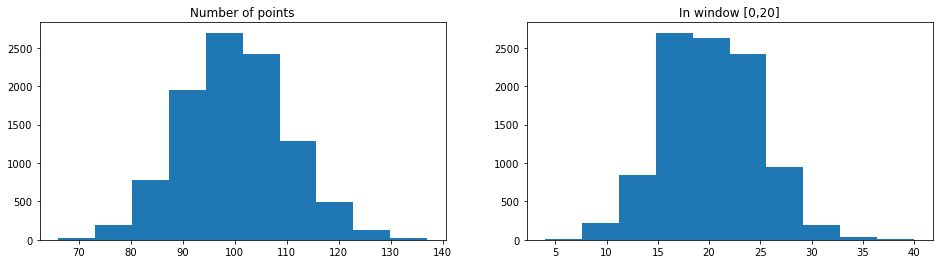

In [6]:
counts = []
window = []
for _ in range(10000):
    times = sampler.sample(0,100)[0]
    counts.append(len(times))
    window.append(np.sum(times <= 20))
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
ax[0].hist(counts)
ax[0].set_title("Number of points")
ax[1].hist(window)
ax[1].set_title("In window [0,20]")
None

## Inhomogeneous Poisson process via factorisation

If the intensity function of the poisson process has the form $\lambda(t,x,y) = \nu(t)\mu(x,y)$ then we can simulate the time-only Poission process with density $\nu$, and then sample the space dimension as if it were a "mark" (see the notion of a "marked Poisson process" in the literature).  If $\mu$ is a probability density of a standard type, this is much faster, because we can very easily draw samples for the space dimensions.

In [43]:
time_kernel = sepp.Exponential(exp_rate=1, total_rate=10)
space_sampler = sepp.GaussianSpaceSampler([50, 50], [150, 25], 0.8)
sampler = sepp.InhomogeneousPoissonFactors(time_kernel, space_sampler)

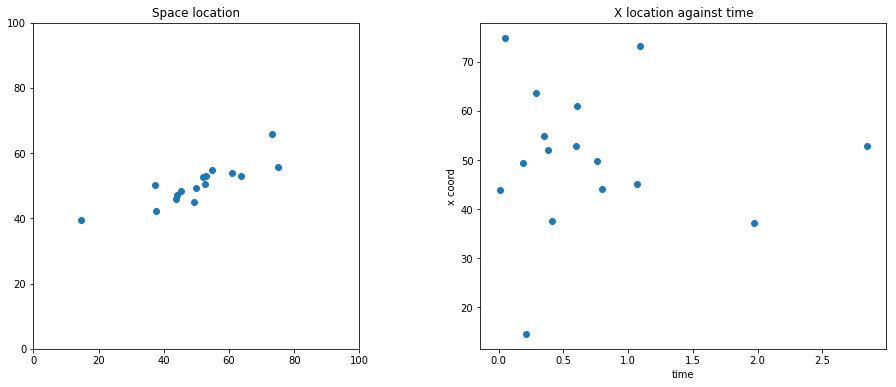

In [44]:
points = sampler.sample(0, 100)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].scatter(points[1], points[2])
ax[0].set_title("Space location")
ax[0].set_aspect(1)
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[1].scatter(points[0], points[1])
ax[1].set_xlabel("time")
ax[1].set_ylabel("x coord")
ax[1].set_title("X location against time")
None

### Self-excited point process sampler

You need to pass two intensity functions (aka kernels), one for the background events, and one for the triggered events.

In the following example, the background sampler has as time component a constant rate poisson process, and a Gaussian space density, centred at (50,50).

The trigger kernel has an exponential density in time (so on average each event triggers one further event) and a space kernel which is deliberate biases to jump around 5 units in the x direction.  We can hence visualise the cascade of triggered events as a rightward drift on the first graph, and an upward drift on the second graph.

In [59]:
background_sampler = sepp.InhomogeneousPoissonFactors(sepp.HomogeneousPoisson(1),
    sepp.GaussianSpaceSampler([50,50], [50,50], 0))

time_kernel = sepp.Exponential(exp_rate=1, total_rate=1)
space_sampler = sepp.GaussianSpaceSampler([5, 0], [1, 1], 0)
trigger_sampler = sepp.InhomogeneousPoissonFactors(time_kernel, space_sampler)

region = open_cp.RectangularRegion(0,100,0,100)
sampler = sepp.SelfExcitingPointProcess(region, background_sampler, trigger_sampler)

In [60]:
points = sampler.sample(0,10)

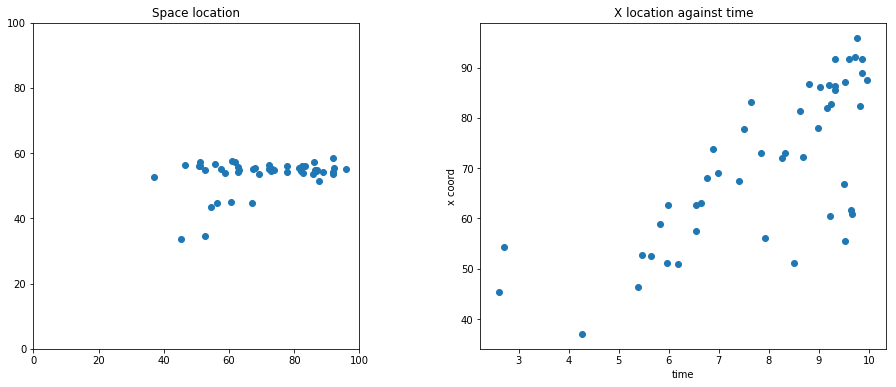

In [61]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].scatter(points[1], points[2])
ax[0].set_title("Space location")
ax[0].set_aspect(1)
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[1].scatter(points[0], points[1])
ax[1].set_xlabel("time")
ax[1].set_ylabel("x coord")
ax[1].set_title("X location against time")
None